In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.linear_model import LogisticRegression

In [30]:
data = pd.read_csv("train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


This is the first five columns of the training data set. 

In [31]:
def drop_nonpredictive_columns(data):
    return data.drop(["Cabin", "PassengerId", "Ticket"], axis=1)

data = drop_nonpredictive_columns(data)
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


Three columns are dropped due to only having purely unique values (Passenger Id) or lots of null values that make it hard to predict anything (Cabin and Ticket).

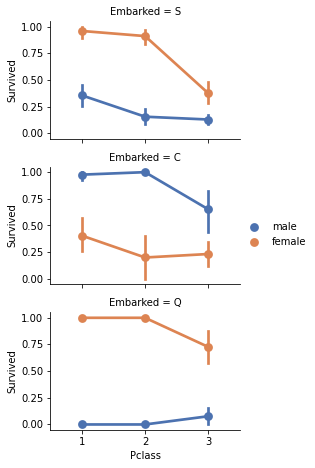

In [32]:
grid = sns.FacetGrid(data, row='Embarked', height=2.2, aspect=1.6)
grid.map_dataframe(sns.pointplot, x = 'Pclass', y = 'Survived', hue = 'Sex', palette='deep')
grid.add_legend();

There is dependence on survival rate that also depends on both sex and port that they embarked on. From these plots, we can see that females were more likely to survive if they left from ports S or Q, but males were more likely to survive if they left from port C.

In [33]:
data.Name.str.extract(', ([A-Za-z]+)', expand=False).value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
the           1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Name, dtype: int64

In [34]:
def categorize_titles(data):
    data['Title'] = data.Name.str.extract(', ([A-Za-z]+)', expand=False)
    replace_titles = {'Title': {"Mr": 1,
                            "Miss": 2, "Mlle": 2, "Ms": 2,
                            "Mrs": 3, "Mme": 3,
                            "Master": 4,
                            "Dr": 5, "Rev": 5, "Major": 5, "Col": 5, "the": 5,
                            "Capt": 5, "Sir": 5, "Lady": 5, "Don": 5, "Jonkheer": 5}}
    data.replace(replace_titles, inplace=True)
    return data.drop("Name", axis=1)

data = categorize_titles(data)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,3
2,1,3,female,26.0,0,0,7.9250,S,2
3,1,1,female,35.0,1,0,53.1000,S,3
4,0,3,male,35.0,0,0,8.0500,S,1


The titles from their names are also extracted and labeled by numbers as this may play a role in their survival rate. This takes into account not only their gender, but also their status or whether they are married or not.

In [35]:
data.groupby("Title", as_index = False).mean()[["Title", "Survived"]].sort_values("Survived", ascending = False)

,Title,Survived
2,3,0.793651
1,2,0.702703
3,4,0.575000
4,5,0.347826
0,1,0.156673


From here we see that non-married women were most likely to survive while married men were the least likely to survive.

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
 8   Title     891 non-null    int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


In [37]:
median_class = data.groupby("Pclass").median()[["Age"]]
median_class

,Age
Pclass,
1,37.0
2,29.0
3,24.0


We separate the median age by class just so we can fill our null value in by a little bit more specific values. However, it's hard to tell whether that will actually make a difference or not since the median values do not actually vary significantly.

In [38]:
def fill_in_missing_values(data):
    median_class = data.groupby("Pclass").median()[["Age"]]
    for i in range(len(data)):
        if np.isnan(data.loc[i]["Age"]):
            data.loc[i, "Age"] = int(median_class.loc[data.loc[i]["Pclass"]])
    data["Embarked"] = data["Embarked"].fillna("Q")
    return data
            
data = fill_in_missing_values(data)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
 8   Title     891 non-null    int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


Now there are no more null values in our dataset!

In [40]:
def additional_cleaning_sex_familysize_fare(data):
    data['Sex'] = (data["Sex"] == "male").astype(int)
    data["FamSize"] = data["SibSp"] + data["Parch"]
    data["log(Fare)"] = np.log(data["Fare"] + 1)
    return data.drop(["SibSp", "Parch", "Fare"], axis=1)

data = additional_cleaning_sex_familysize_fare(data)
data.head()

,Survived,Pclass,Sex,Age,Embarked,Title,FamSize,log(Fare)
0,0,3,1,22.0,S,1,1,2.110213
1,1,1,0,38.0,C,3,1,4.280593
2,1,3,0,26.0,S,2,0,2.188856
3,1,1,0,35.0,S,3,1,3.990834
4,0,3,1,35.0,S,1,0,2.202765


In [41]:
def categorize_onehot(data):
    return pd.get_dummies(data, columns = ["Pclass", "Embarked", "Title"], drop_first = True)

data = categorize_onehot(data)
data

,Survived,Sex,Age,FamSize,log(Fare),Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Title_2,Title_3,Title_4,Title_5
0,0,1,22.0,1,2.110213,0,1,0,1,0,0,0,0
1,1,0,38.0,1,4.280593,0,0,0,0,0,1,0,0
2,1,0,26.0,0,2.188856,0,1,0,1,1,0,0,0
3,1,0,35.0,1,3.990834,0,0,0,1,0,1,0,0
4,0,1,35.0,0,2.202765,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,27.0,0,2.639057,1,0,0,1,0,0,0,1
887,1,0,19.0,0,3.433987,0,0,0,1,1,0,0,0
888,0,0,24.0,3,3.196630,0,1,0,1,1,0,0,0
889,1,1,26.0,0,3.433987,0,0,0,0,0,0,0,0


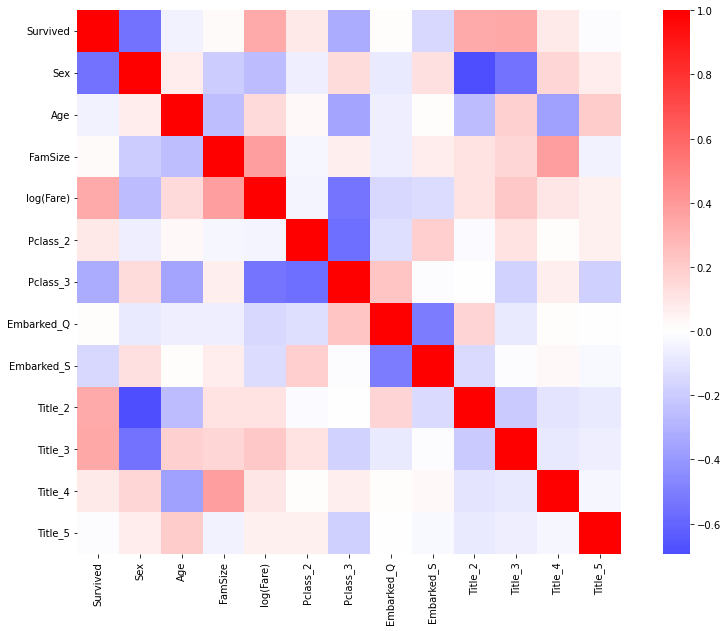

In [42]:
plt.figure(figsize=(15,10))
sns.heatmap(pd.DataFrame(data, columns=data.columns).corr(), square = True, center = 0, cmap = "bwr");

In [43]:
def load_process_data(path_name):
    return (pd.read_csv(path_name)
            .pipe(drop_nonpredictive_columns)
            .pipe(categorize_titles)
            .pipe(fill_in_missing_values)
            .pipe(additional_cleaning_sex_familysize_fare)
            .pipe(categorize_onehot))

In [44]:
data = load_process_data("train.csv")
data.columns

Index(['Survived', 'Sex', 'Age', 'FamSize', 'log(Fare)', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S', 'Title_2', 'Title_3', 'Title_4',
       'Title_5'],
      dtype='object')

In [45]:
Y = data["Survived"]
X = data.drop(["Survived"], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

lr = LogisticRegression(
        multi_class="ovr",
        fit_intercept=True,
        solver = 'lbfgs',
        max_iter=30000)

lr.fit(X_train, Y_train)
lr.intercept_, lr.coef_

(array([1.57183868]),
 array([[-2.13782954, -0.03113997, -0.42279472,  0.41744087, -0.69570903,
         -1.62623517, -0.1089465 , -0.23102129,  0.5668188 ,  1.23263021,
          2.41262213, -0.01573783]]))

In [46]:
train_accuracy = sum(lr.predict(X_train) == Y_train) / len(Y_train)
test_accuracy = sum(lr.predict(X_test) == Y_test) / len(Y_test)

print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Train accuracy: 0.8353
Test accuracy: 0.8296


In [47]:
test = load_process_data("test.csv").fillna(0)
for label in test.columns:
    if label not in X.columns:
        test = test.drop([label], axis=1)

prediction = pd.DataFrame(lr.predict(test), columns = ["Survived"])

In [48]:
prediction["PassengerId"] = pd.read_csv("test.csv")["PassengerId"]
prediction

,Survived,PassengerId
0,0,892
1,0,893
2,0,894
3,0,895
4,1,896
...,...,...
413,0,1305
414,1,1306
415,0,1307
416,0,1308


In [49]:
prediction.to_csv("prediction_test_titanic.csv", index = False)

In [50]:
test

,Sex,Age,FamSize,log(Fare),Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Title_2,Title_3,Title_4,Title_5
0,1,34.5,0,2.178064,0,1,1,0,0,0,0,0
1,0,47.0,1,2.079442,0,1,0,1,0,1,0,0
2,1,62.0,0,2.369075,1,0,1,0,0,0,0,0
3,1,27.0,0,2.268252,0,1,0,1,0,0,0,0
4,0,22.0,2,2.586824,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1,24.0,0,2.202765,0,1,0,1,0,0,0,0
414,0,39.0,0,4.699571,0,0,0,0,0,0,0,0
415,1,38.5,0,2.110213,0,1,0,1,0,0,0,0
416,1,24.0,0,2.202765,0,1,0,1,0,0,0,0
